In [140]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import warnings


import numpy as np
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print("Num GPU:", len(physical_device))
tf.config.experimental.set_memory_growth(physical_device[0], True)

Num GPU: 1


# Data Preparation

## Dataset: Cat vs Dog
### Source: https://www.kaggle.com/c/dogs-vs-cats

In [36]:
# Реорганизация данных -> (тренировочная, валидационная, тестовая выборка)
os.chdir('Dataset')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    

    
#
#os.chdir('../../')

In [6]:
path = 'F:\Git_Clone\Cat_Dog_Classifications_Keras/Dataset/'

In [50]:
#get in random data
for c in random.sample(glob.glob(path+'train/cat*'), 500):
    shutil.move(c, path+'train/cat')
for c in random.sample(glob.glob(path+'train/dog*'), 500):
    shutil.move(c, path+'train/dog')
for c in random.sample(glob.glob(path+'train/cat*'), 100):
    shutil.move(c, path+'valid/cat')
for c in random.sample(glob.glob(path+'train/dog*'), 100):
    shutil.move(c, path+'valid/dog')   
for c in random.sample(glob.glob(path+'train/cat*'), 100):
    shutil.move(c, path+'test/cat')
for c in random.sample(glob.glob(path+'train/dog*'), 100):
       shutil.move(c, path+'test/dog')  

In [7]:
train_path = path + 'train'
valid_path = path + 'valid'
test_path = path + 'test'

In [117]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = train_path, target_size = (224,224),  batch_size = 32, classes = ['cat','dog'])
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = valid_path, target_size = (224,224), classes = ['cat','dog'], batch_size = 32)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = test_path, target_size = (224,224), classes = ['cat','dog'], batch_size = 32, shuffle = False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [118]:
#check prepare data
imgs, labels = next(train_batches)

In [119]:
# функция отображения набора ПРЕДОБРАБОТАННЫХ данных
def plot_images(images_arr, batch_size = 10):
    fig, axes = plt.subplots(1,batch_size, figsize = (20,20))
    axes = axes.flatten()
    for img , ax in zip(images_arr, axes):
        #ax.imshow(img)
        ax.imshow((img * 255).astype(np.uint8)) # not work...
        
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

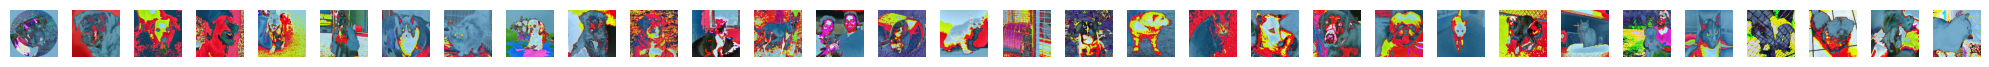

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [98]:
plot_images(imgs, batch_size = 32)
print(labels) #[1,0] - cat | [0,1] - dog

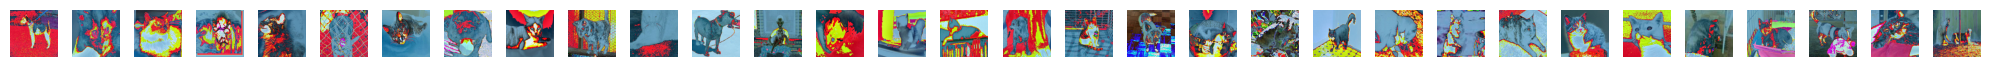

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [120]:
imgs, labels = next(valid_batches)
plot_images(imgs, batch_size = 32)
print(labels) #[1,0] - cat | [0,1] - dog

# Build and Train CNN

In [121]:
def get_model(lr):
    model = Sequential([
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = (224,224,3)), #same - input zero data
        MaxPool2D(pool_size = (2,2), strides = 2),
        Dropout(0.2),
        Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', ),
        MaxPool2D(pool_size = (2,2), strides = 2),
        Dropout(0.4),
        Flatten(),

        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(units = 2, activation = 'softmax')
        
    ])
    
    model.summary()
    model.compile(optimizer = Adam(learning_rate =lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [122]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('sparse_categorical_crossentropy')
  ax1.legend()
  
  ax1.grid(True)


  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  ax2.grid(True)



  plt.show()

In [145]:
def get_pred_report(model, x, test_y):
  predictions = model.predict(x = x, batch_size= 32, verbose = 0)
  predictions = np.argmax(predictions, axis =-1)
  print(classification_report(predictions, test_y))
  return predictions

In [162]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    uncm = cm.copy()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

   

    fmt = '.2f' if normalize else 'd'
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(uncm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [125]:
def fit_models(model, train_batches, valid_batches, epochs = 10, verbose = 2):
    history = model.fit(
        x = train_batches,
        validation_data = valid_batches,
        epochs = epochs,
        verbose = verbose
    )
    
    return model, history
    

In [127]:
cnn_model = get_model(lr = 0.0001)
cnn_model, history = fit_models(cnn_model, train_batches, valid_batches, epochs = 25)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 56, 56, 64)      

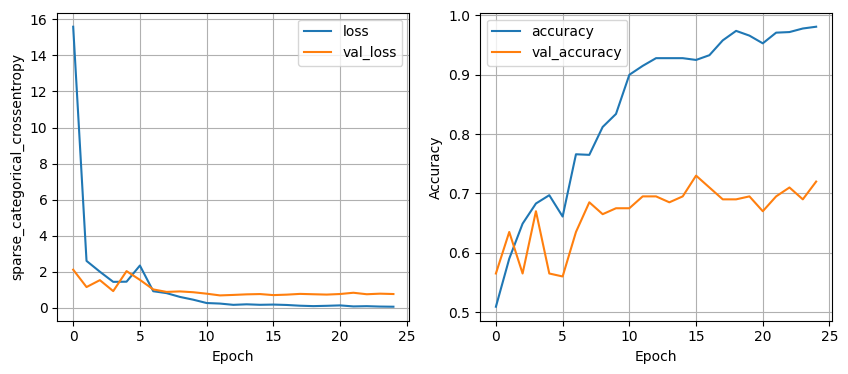

In [128]:
plot_history(history)

valid accuracy....

# Predict

In [129]:
test_imgs, test_labels = next(test_batches)

In [135]:
predict = cnn_model.predict(x = test_batches)

7/7 [==============================] - 1s 156ms/step


In [136]:
np.round(predict)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [137]:
test_batches.classes.shape

(200,)

In [151]:
predictions = get_pred_report(cnn_model,test_batches,test_batches.classes)

              precision    recall  f1-score   support

           0       0.72      0.66      0.69       109
           1       0.63      0.69      0.66        91

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.67       200
weighted avg       0.68      0.68      0.68       200



In [152]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = predictions)

[[72 28]
 [37 63]]


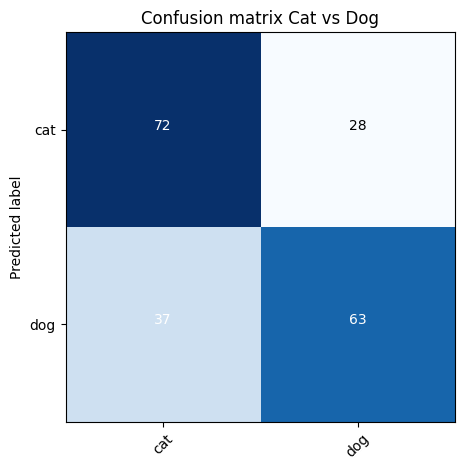

In [163]:
cm_plot_labels = ['cat', 'dog']
plot_conflusion_matrix(cm = cm, classes=cm_plot_labels, title = "Confusion matrix Cat vs Dog")